<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/econml/cm_causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!ls

build  cm_causality.ipynb  econML_readDocumet.ipynb  LightGBM


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML

/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML


In [3]:
ls

cm_causality.ipynb  econML_readDocumet.ipynb


In [0]:
def time_watch(func):
    """時間計測用デコレータ関数
    
    Parameters
    -----
    func : function
        実行したい関数

    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = datetime.datetime.today()
        result = func(*args, **kwargs)
        end = datetime.datetime.today()
        print("実行時間:{time}".format(time=end - start))
        return result
    return wrapper

# アプリのCMを見たことで、アプリの利用時間がどのくらい増加したか分析（CATEの算出）

## データの前処理

### 分析対象のデータ読み込み

In [0]:
# utils
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

In [0]:
DATA_DIR = "../datasets"
CSV_FIEL = "game_cm_abtest.csv"
data_path = DATA_DIR + "/" + CSV_FIEL

In [7]:
read_data = pd.read_csv(data_path)
read_data.head(3)

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0


In [8]:
# 欠損数及び統計量の確認
read_data.describe()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.414400,0.074000,0.091200,0.588700,0.111500,0.208600,40.841900,0.640300,0.647000,0.566200,0.054200,0.075900,0.012300,0.117700,0.099900,0.039900,0.033900,357.829700,3.55234,0.148000,0.144800,0.620400,0.069900,0.016900,0.42300,0.013200,0.127800,0.173300,0.052200,0.140300,0.328800,0.164400,8096.497203,2846.783400,9.433300
std,0.492643,0.261784,0.287908,0.492094,0.314766,0.406328,10.465434,0.479936,0.477927,0.495623,0.226423,0.264851,0.110227,0.322269,0.299882,0.195734,0.180981,267.408383,3.37777,0.355118,0.351917,0.485312,0.254991,0.128903,0.49406,0.114136,0.333884,0.378525,0.222441,0.347315,0.469801,0.370657,7709.497437,17973.608991,54.475214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.875270,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2502.245967,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,349.500000,2.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5944.444520,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,549.500000,4.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11154.786148,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,800.000000,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,49036.055042,364814.000000,765.000000


### アウトカムの分布を確認

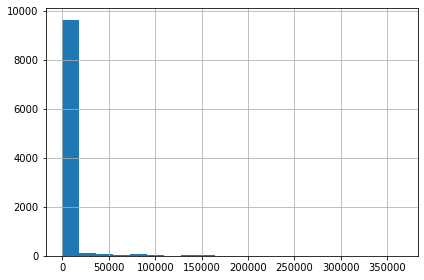

In [70]:
read_data[OUTCOME_COLUMN].hist(bins=20)
plt.tight_layout()
plt.show()

### カラムの整理

In [9]:
UNNECESSARY_COLUMNS = ["gamedummy", "gamecount"]
analysis_data = read_data.drop(columns=UNNECESSARY_COLUMNS)
analysis_data.head(1)

,cm_dummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond
0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.4276,0


In [0]:
# 介入変数
TREATMENT_COLUMN = "cm_dummy"
# アウトカム
OUTCOME_COLUMN = "gamesecond"
# 交絡因子
COVARIATE_COLUMNS = [c for c in analysis_data.columns if c != TREATMENT_COLUMN and c != OUTCOME_COLUMN]

### 訓練データとテストデータに分割

In [0]:
from sklearn.model_selection import train_test_split

In [12]:
train_data, test_data = train_test_split(analysis_data, test_size=0.2, shuffle=True, random_state=7)
print("分割前のデータサイズ:{size}".format(size=analysis_data.shape))
print("訓練データサイズ:{size}".format(size=train_data.shape))
print("訓練データサイズ:{size}".format(size=test_data.shape))

分割前のデータサイズ:(10000, 33)
訓練データサイズ:(8000, 33)
訓練データサイズ:(2000, 33)


#### アウトカムの統計量の差を確認

In [82]:
print("---訓練データ内のアウトカムの統計量---\n{num}\n".format(num=train_data[OUTCOME_COLUMN].describe()))
print("---テストデータ内のアウトカムの統計量---\n{num}\n".format(num=test_data[OUTCOME_COLUMN].describe()))

---訓練データ内のアウトカムの統計量---
count      8000.000000
mean       2962.627250
std       18693.136545
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64

---テストデータ内のアウトカムの統計量---
count      2000.000000
mean       2383.408000
std       14743.580547
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      223095.000000
Name: gamesecond, dtype: float64



## MetaLeanerを使った因果推論

### ライブラリのインストール
- econml（マイクロソフト）

In [13]:
!pip install econml

In [0]:
# LightGBM使う際のおまじない(https://qiita.com/wakame1367/items/bcf8b760260329fb7136)
"""
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
"""
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

### X-Leanerモデルの定義と訓練

In [0]:
from econml.metalearners import XLearner
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [0]:
XLEANER_MODEL = XLearner(models=GradientBoostingRegressor(), # （反事実も含めた）アウトカム予測用のモデル定義
                         propensity_model=GradientBoostingClassifier(), # 傾向スコア予測用のモデル定義
                         cate_models=GradientBoostingRegressor() # CATE予測用のモデル定義
                         )

In [16]:
# 訓練の実行
XLEANER_MODEL.fit(Y=train_data[OUTCOME_COLUMN].values, # アウトカム
                  T=train_data[TREATMENT_COLUMN].values, # 介入変数
                  X=train_data[COVARIATE_COLUMNS].values, # 交絡因子
                  inference="bootstrap" # ブートストラップを使った信頼区間の構築
                  )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


In [0]:
import lightgbm as lgb

In [0]:
XLEANER_MODEL2 = XLearner(models=lgb.LGBMRegressor(), # （反事実も含めた）アウトカム予測用のモデル定義
                         propensity_model=lgb.LGBMClassifier(), # 傾向スコア予測用のモデル定義
                         cate_models=lgb.LGBMRegressor() # CATE予測用のモデル定義
                         )

In [20]:
XLEANER_MODEL2.fit(Y=train_data[OUTCOME_COLUMN].values, # アウトカム
                  T=train_data[TREATMENT_COLUMN].values, # 介入変数
                  X=train_data[COVARIATE_COLUMNS].values, # 交絡因子
                  inference="bootstrap" # ブートストラップを使った信頼区間の構築
                  )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [0]:
model1_est = XLEANER_MODEL.effect(test_data[COVARIATE_COLUMNS])
model2_est = XLEANER_MODEL2.effect(test_data[COVARIATE_COLUMNS])

In [58]:
pd.DataFrame(pd.Series(model1_est.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,2000.0,991.145826,11099.327508,-47795.413847,-1974.853067,-664.970535,748.782905,99796.97355


In [59]:
pd.DataFrame(pd.Series(model2_est.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,2000.0,845.064669,12608.197418,-66819.94174,-4120.833734,-383.143939,3670.997606,100944.555613


## Interpreterを使って結果を描画

In [0]:
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)

In [91]:
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(XLEANER_MODEL2, test_data[COVARIATE_COLUMNS])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


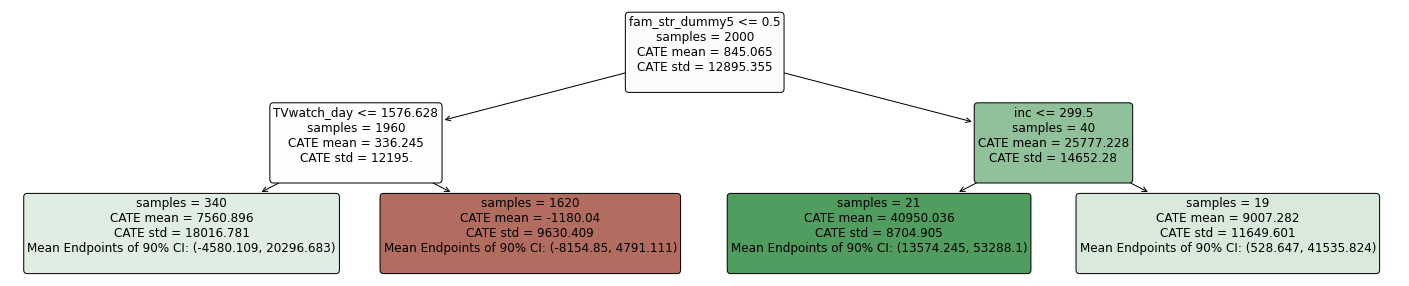

In [93]:
# Plot the tree
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=COVARIATE_COLUMNS, fontsize=12)
plt.show()

In [94]:
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(XLEANER_MODEL, test_data[COVARIATE_COLUMNS])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


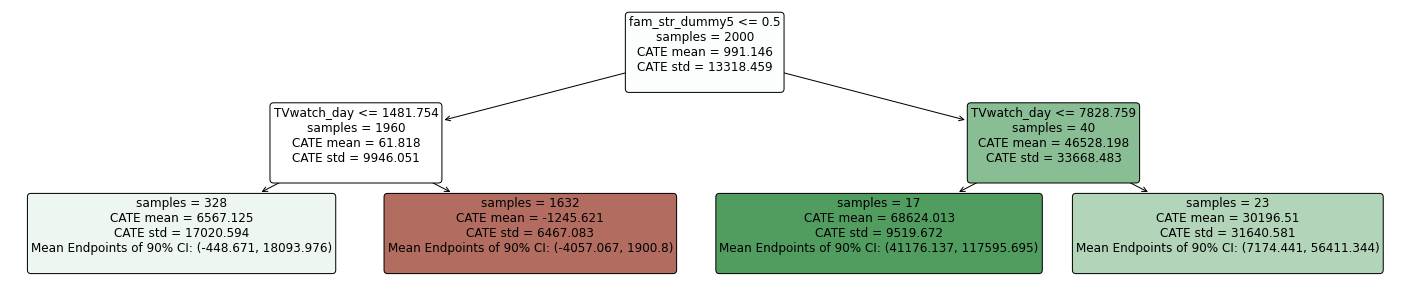

In [95]:
# Plot the tree
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=COVARIATE_COLUMNS, fontsize=12)
plt.show()